In [20]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, output_notebook

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [5]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

## Carevue fluid outliers -- high amounts.
We are including OR and PACU fluids in our fluid balance calculations.  Do these lead to outliers?

In [37]:
# carevue OR fluids codes.  
sql = """select * 
from mimiciii.inputevents_cv
where itemid in ('30101', '30102') 
and amount is not null
order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head()

,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,...,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,937761,7413,134105.0,219750.0,2172-11-04 23:00:00,30101,33000.0,ml,None,None,...,3045093,3045093,None,NaN,NaN,ml,Intravenous Push,None,None,None
1,936251,11353,108739.0,286981.0,2113-05-30 13:00:00,30101,30000.0,ml,None,None,...,5785664,5785664,None,NaN,NaN,ml,Intravenous Push,None,None,None
2,904217,18463,128430.0,253611.0,2173-11-06 00:15:00,30101,22000.0,ml,None,None,...,9810761,9810761,None,NaN,NaN,ml,Intravenous Push,None,None,None
3,937637,19095,131302.0,210780.0,2143-11-12 18:00:00,30102,19836.0,ml,None,None,...,4010437,4010437,None,NaN,NaN,ml,Intravenous Push,None,None,None
4,946177,20854,120046.0,288220.0,2157-04-29 20:00:00,30102,19375.0,ml,None,None,...,10468351,10468351,None,1.0,NaN,ml,Intravenous Push,None,None,None


(array([  1.44160000e+04,   3.88900000e+03,   1.87000000e+03,
          7.38000000e+02,   2.77000000e+02,   7.90000000e+01,
          9.00000000e+01,   3.80000000e+01,   1.90000000e+01,
          1.60000000e+01,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([     0.,   1650.,   3300.,   4950.,   6600.,   8250.,   9900.,
         11550.,  13200.,  14850.,  16500.,  18150.,  19800.,  21450.,
         23100.,  24750.,  26400.,  28050.,  29700.,  31350.,  33000.]),
 <a list of 20 Patch objects>)

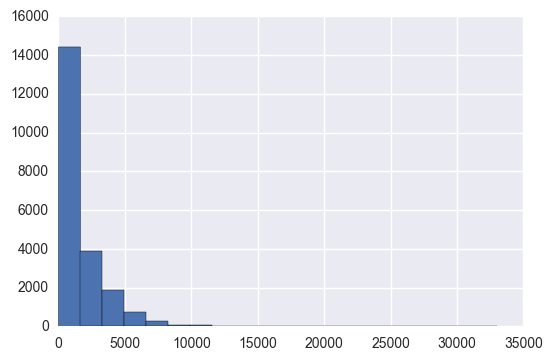

In [7]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)

In [22]:
output_notebook()
p = figure(
   tools="pan,box_zoom,reset,save",
   title="Carevue OR fluid amounts",
   x_axis_label='amount', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p)

Loading BokehJS ...

In [46]:
sql = """
select * 
from fluid_cv_itemtotal
order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head(100)

,icustay_id,day_since_admission,itemid,label,amount
0,219750,0.0,30101,OR Crystalloid,33000.0
1,245712,0.0,30030,Sodium Bicarbonate,30300.0
2,202865,48.0,30168,Normal Saline_GU,30000.0
3,286981,0.0,30101,OR Crystalloid,30000.0
4,253611,0.0,30101,OR Crystalloid,22000.0
5,210780,0.0,30102,OR Colloid,19836.0
6,288220,0.0,30102,OR Colloid,19375.0
7,223601,0.0,30101,OR Crystalloid,19000.0
8,245712,0.0,30030,Sodium Bicarbonate,18937.5
9,221955,0.0,30101,OR Crystalloid,18670.0


In [48]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p2 = figure(
   tools="pan,box_zoom,reset,save",
   title="Carevue fluid single item amounts",
   x_axis_label='amount', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p2)

Loading BokehJS ...

## OR and PACU fluids do not end up in final extract because they are all preadmission??

In [23]:
## OR, PACU fluid from Metavision. empty results, so OR fluids not contributing to high fluid volumes.

sql = """SELECT row_id, subject_id, hadm_id, icustay_id, starttime, endtime, 
       itemid, amount, amountuom, rate, rateuom, storetime, patientweight, totalamount, totalamountuom, 
       isopenbag, continueinnextdept, cancelreason, statusdescription, 
       comments_editedby, comments_canceledby, comments_date,originalamount, 
       originalrate
  FROM mimiciii.inputevents_mv
  where itemid in ('226364', '226375', '226365', '226367')
  and amount > 0  -- amount can be negative, often for REWRITTEN orders.  
		and cancelreason = 0 -- some orders are cancelled
		and statusdescription != 'Rewritten'  -- not sure if this should be a filter.
		and ordercategoryname not like '%Pre Admission%' -- Pre Admission fluid can be very high and cover uncertain amount of time.  
		and icustay_id is not null
  order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head()

,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate


## Metavision, top amounts of fluid 

In [30]:
sql = """SELECT f.row_id, f.subject_id, f.icustay_id, f.hadm_id, f.itemid, d.label, f.rate, f.amount, 
       starttime, endtime
  FROM mimiciii.fluid_mv_itemtotal as f
  join d_items as d
  on f.itemid = d.itemid
order by amount desc"""
df = pd.read_sql_query(sql, conn)


In [34]:
df.head(100)

,row_id,subject_id,icustay_id,hadm_id,itemid,label,rate,amount,starttime,endtime
0,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-10 00:00:00,2153-10-11 00:00:00
1,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-09 00:00:00,2153-10-10 00:00:00
2,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-11 00:00:00,2153-10-11 05:25:00
3,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-07 00:00:00,2153-10-08 00:00:00
4,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-04 23:35:00,2153-10-05 00:00:00
5,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-06 00:00:00,2153-10-07 00:00:00
6,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-08 00:00:00,2153-10-09 00:00:00
7,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-05 00:00:00,2153-10-06 00:00:00
8,711219,64590,253402,160850,225168,Packed Red Blood Cells,14250.000000,14250.000000,2123-04-06 03:27:00,2123-04-06 04:27:00
9,711213,64590,253402,160850,220970,Fresh Frozen Plasma,13800.000000,13800.000000,2123-04-06 03:31:00,2123-04-06 04:31:00


In [31]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p1 = figure(
   tools="pan,box_zoom,reset,save",
   title="Metavision fluid single item amounts",
   x_axis_label='amount', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p1)

Loading BokehJS ...